In [1]:
import os

os.chdir(r'C:\Users\carlo\GitHub\ProjectBuffalo')

import buffalo.ingestion as ingestion
import buffalo.predictor as predictor
import torch
import pickle

In [ ]:
ingestor = ingestion.DataIngestion(ingestion.enum.API.ADVANTAGE)

In [ ]:
ingestor.load_data(r'cached_data/ingestion.sqlite')

In [ ]:
target_symbol = 'AAPL'

In [ ]:
ingestor.data['ADJUSTED_DAILY_STOCK'].symbol.unique()

In [ ]:
target_stock = ingestor.data['ADJUSTED_DAILY_STOCK'].query('symbol == @target_symbol')[['open', 'high', 'low', 'adjusted_close', 'volume']]

In [ ]:
other_stocks = ingestor.data['ADJUSTED_DAILY_STOCK'].query('symbol != "AAPL"')

In [ ]:
for symbol in ['MSFT', 'IBM', 'JNJ', 'PFE', 'UNH', 'XLV', 'JPM', 'BAC', 'GS', 'XLF', 'PG', 'KO', 'PEP', 'NKE', 'XLP', 'GE', 'HON', 'MMM', 'XLI']:
    temp = other_stocks[other_stocks['symbol'] == symbol][['open', 'high', 'low', 'adjusted_close', 'volume']].rename(columns={'adjusted_close': 'close'})
    temp.columns = symbol + '_' + temp.columns
    target_stock = predictor.util.align_dataframe_by_time(target_stock, temp)

In [ ]:
target_income_statement = ingestor.data['COMPANY_INCOME_STATEMENT'].query('symbol == @target_symbol & freq == "quarterly"').drop(columns=['reported_currency', 'symbol', 'freq', 'function']).dropna(axis=1, how='all')
target_balance_sheet = ingestor.data['COMPANY_BALANCE_SHEET'].query('symbol == @target_symbol & freq == "quarterly"').drop(columns=['reported_currency', 'symbol', 'freq', 'function']).dropna(axis=1, how='all')
target_cash_flow = ingestor.data['COMPANY_CASH_FLOW'].query('symbol == @target_symbol & freq == "quarterly"').drop(columns=['reported_currency', 'symbol', 'freq', 'function', 'net_income']).dropna(axis=1, how='all')
fed_funds_rate = ingestor.data['FEDERAL_FUNDS_RATE'][['value']].rename(columns={'value': 'effective_federal_funds_rate'}).dropna(axis=1, how='all')
payroll = ingestor.data['NONFARM_PAYROLL'][['value']].rename(columns={'value': 'total_nonfarm_payroll'}).dropna(axis=1, how='all')
cpi = ingestor.data['CPI'][['value']].rename(columns={'value': 'consumer_price_index'}).dropna(axis=1, how='all')
unemployment = ingestor.data['UNEMPLOYMENT'][['value']].rename(columns={'value': 'unemployment_rate'}).dropna(axis=1, how='all')
real_gdp = ingestor.data['REAL_GDP'][['value']].rename(columns={'value': 'real_gross_domestic_product'}).dropna(axis=1, how='all')
real_gdp_per_capita = ingestor.data['REAL_GDP_PER_CAPITA'][['value']].rename(columns={'value': 'real_gross_domestic_product_per_capita'})
treasury_yield = ingestor.data['TREASURY_YIELD'][['value', 'maturity']].pivot(columns=['maturity'], values=['value']).dropna(axis=1, how='all')
treasury_yield.columns = 'treasury_yield_' + treasury_yield.columns.droplevel(level=0)

In [ ]:
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, fed_funds_rate)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, payroll)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, cpi)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, unemployment)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, real_gdp)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, real_gdp_per_capita)
print(target_stock.shape)
target_stock = predictor.util.align_dataframe_by_time(target_stock, treasury_yield)
print(target_stock.shape)
#target_stock = predictor.util.align_dataframe_by_time(target_stock, target_income_statement)
#print(target_stock.shape)
#target_stock = predictor.util.align_dataframe_by_time(target_stock, target_balance_sheet)
#print(target_stock.shape)
#target_stock = predictor.util.align_dataframe_by_time(target_stock, target_cash_flow)
#print(target_stock.shape)

In [ ]:
pickle.dump(target_stock, open(r'cached_data/target_stock.pickle', 'wb'))

In [3]:
target_stock = pickle.load(open('cached_data/target_stock.pickle', 'rb'))

In [4]:
time_series_data = predictor.util.TimeSeriesData(endog=target_stock[['adjusted_close']], exog=target_stock.drop(columns=['adjusted_close']), seq_len=180, name='DAILY_ADJUSTED_CLOSE_APPL')

In [5]:
import buffalo.predictor.models as modeling

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 240.30150178074837. Test loss: 10459.934505462646.


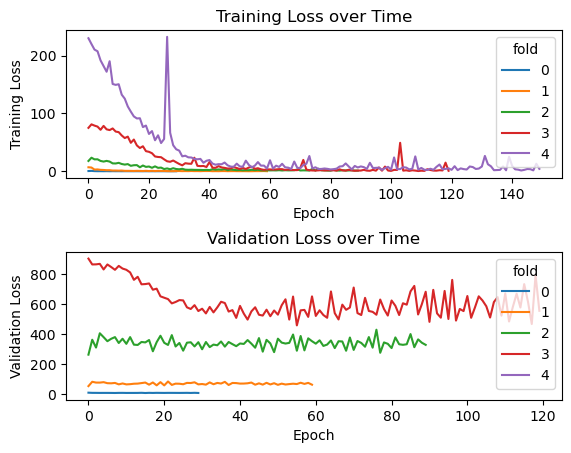

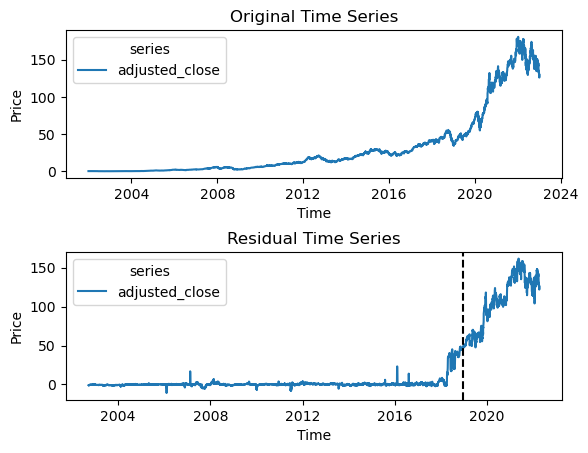

In [6]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=2, dropout=0.2, bidirectional=False, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 248.71977474139288. Test loss: 9945.418583869934.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 1, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")


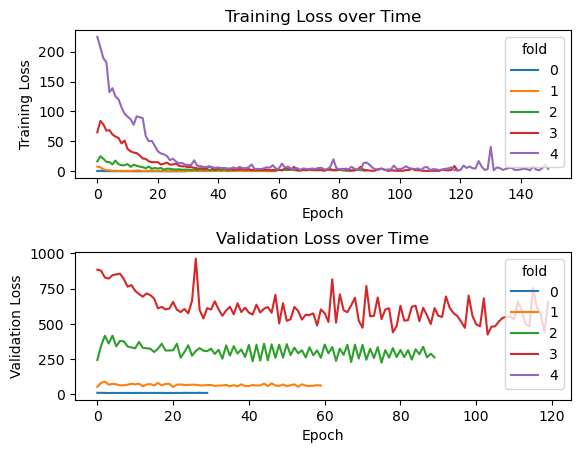

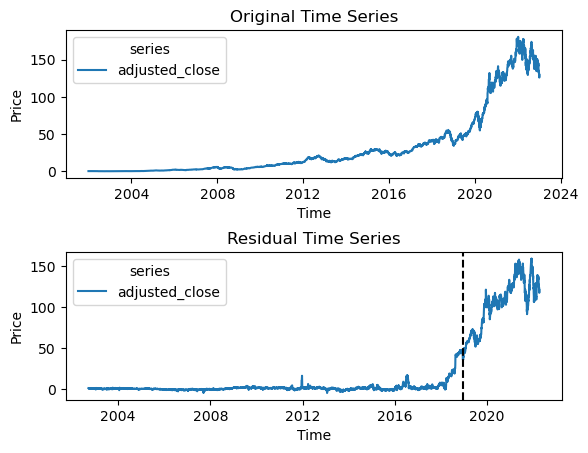

In [7]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=2, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 197.34702264073377. Test loss: 10466.720127105713.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 1, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")


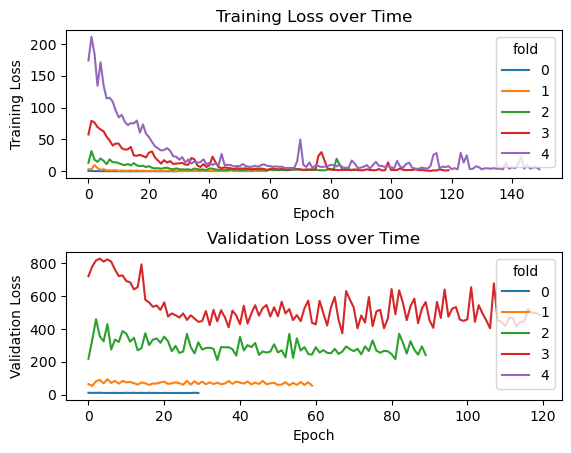

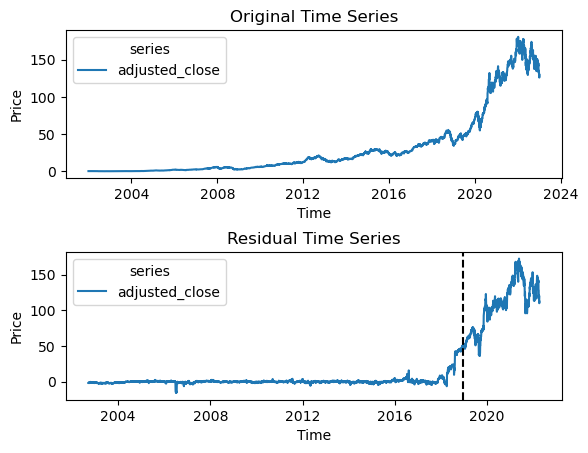

In [8]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=3, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 298.6690008448294. Test loss: 9881.635333061218.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 1, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")


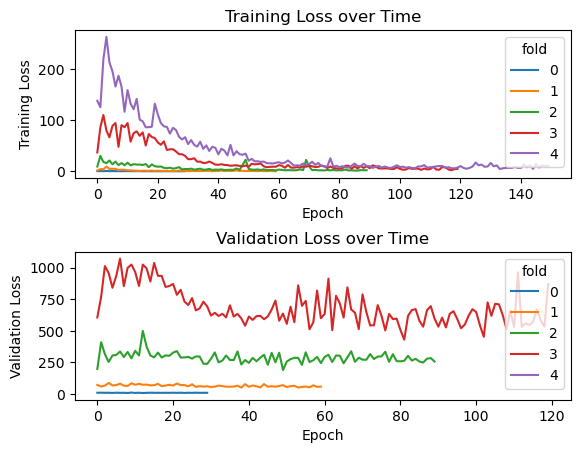

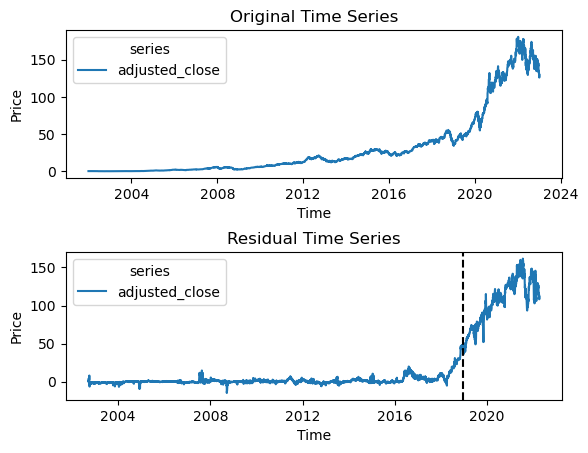

In [9]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=4, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 204.00897568750838. Test loss: 10580.233861923218.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 1, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")


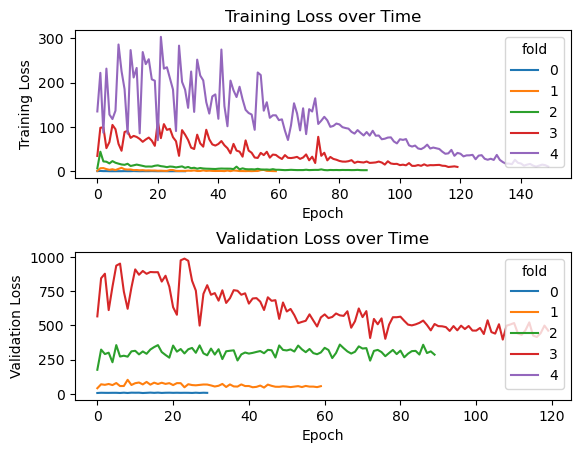

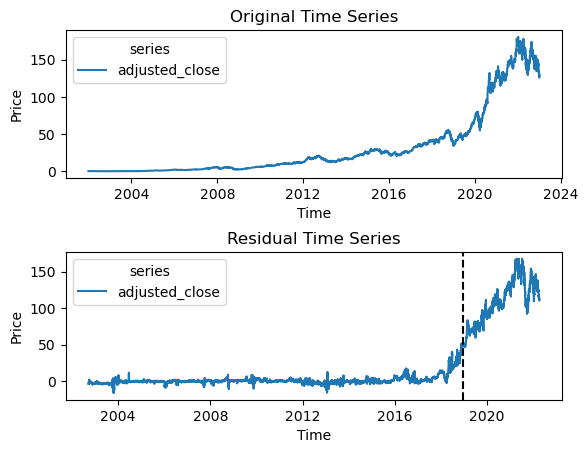

In [10]:
rnn = modeling.RNN(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=5, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(rnn, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 258.47101989689355. Test loss: 11208.377597808838.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 1, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")


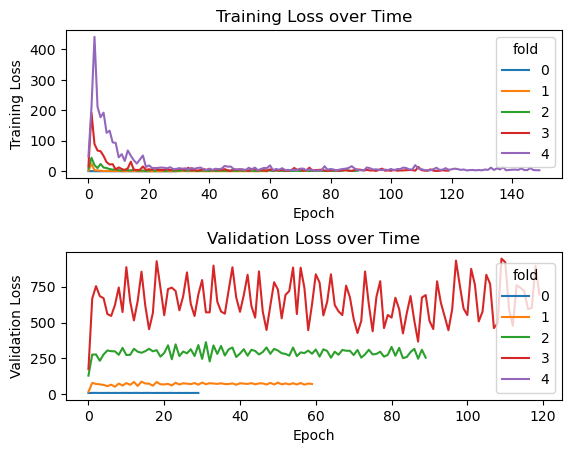

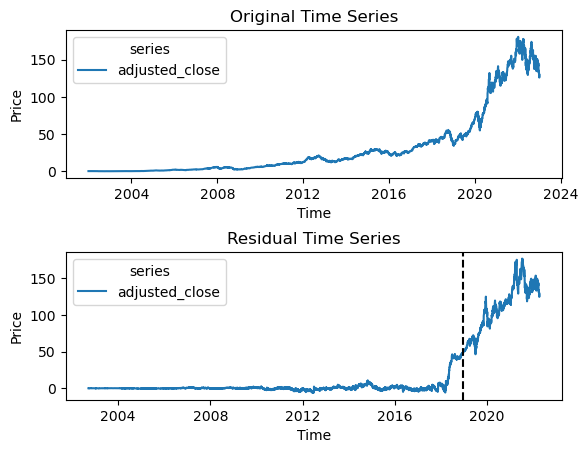

In [11]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=2, dropout=0.2, bidirectional=False, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 265.64443151423563. Test loss: 12011.943832397461.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 1, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")


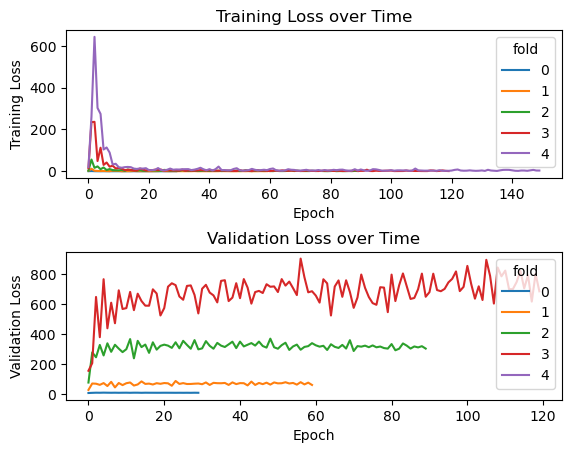

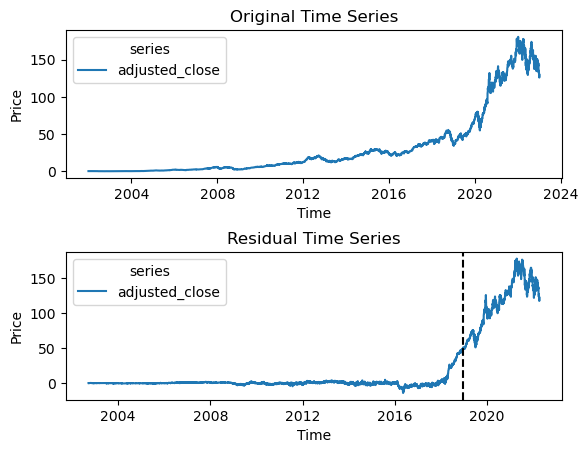

In [12]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=2, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 303.91481622938926. Test loss: 10818.430681228638.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 1, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")


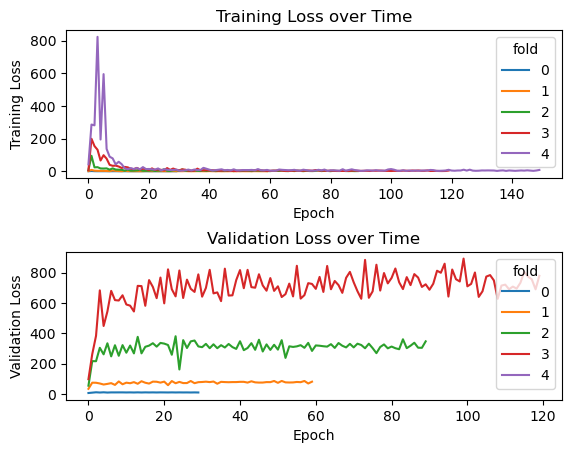

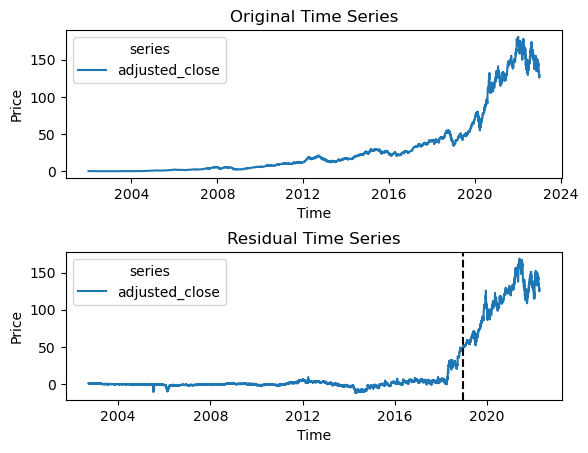

In [13]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=3, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 246.20884253199284. Test loss: 10307.768295288086.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 1, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")


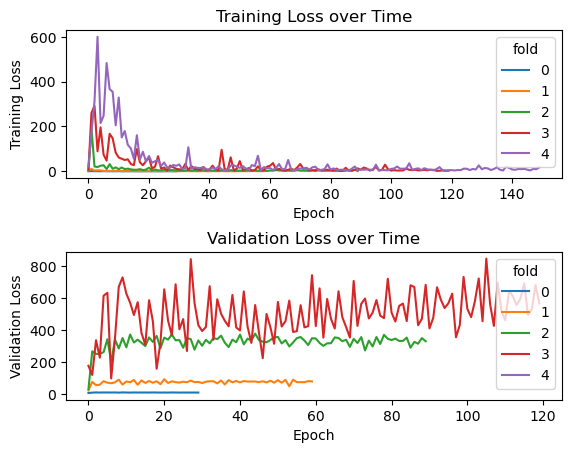

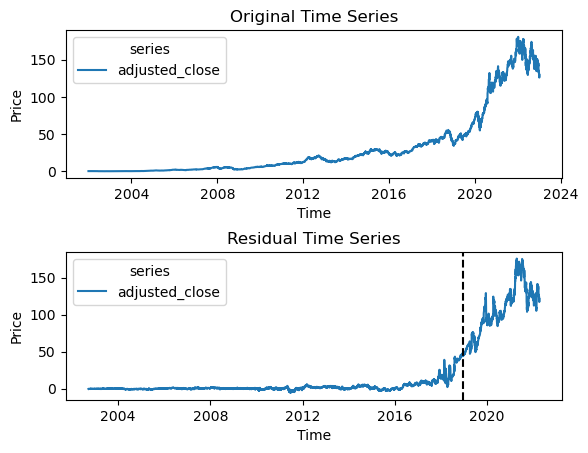

In [14]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=4, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()

Multi-fold validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Averaged validation loss: 219.3334761032691. Test loss: 11373.839698791504.


C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\predictor\util.py:224: UserWarning: dataset_info with the same primary keys already exists with id 1, will not store dataset information.
  warn(f"dataset_info with the same primary keys already exists with id {searched_id}, will not store dataset information.")


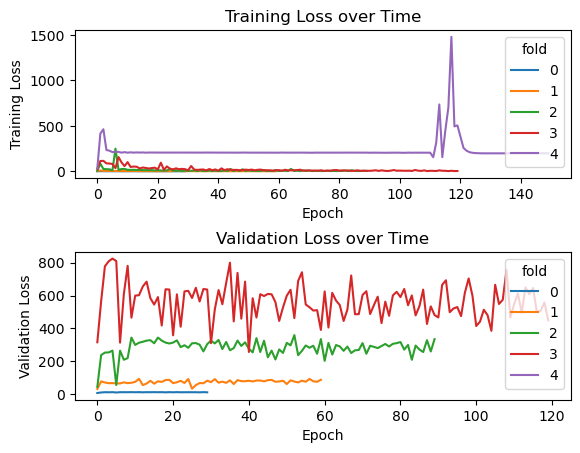

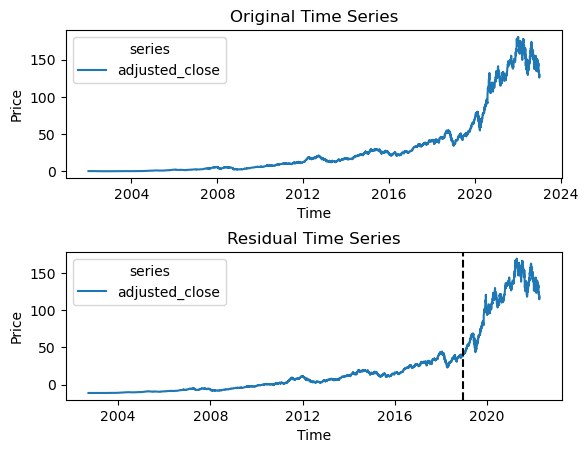

In [15]:
lstm = modeling.LSTM(input_size=target_stock.shape[1], hidden_size=64, output_size=1, num_layers=5, dropout=0.2, bidirectional=True, use_gpu=True)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()
training_record = modeling.train_and_evaluate_model(lstm, optimizer, loss_func, time_series_data, 30, 0.2, 5, clip_grad=1, batch_size=64) # Pointwise prediction
training_record.serialize_to_file(r'cached_data/record.sqlite', additional_note_dataset='', additonal_note_model='')
training_record.plot_training_records()
training_record.plot_residuals()